In [1]:
using Glob
using JSON
using LargeScaleAnalysis
using LargeScaleAnalysis.Fetchmesh
using ProgressMeter
using PyCall
using PyPlot
using Statistics
using StatsBase

┌ Info: Precompiling LargeScaleAnalysis [795b8d18-bbeb-4217-80b2-db63563e71da]
└ @ Base loading.jl:1260


In [2]:
include("../../ParsimoniousMonitoring/notebooks/thesis.jl")

save_thesis (generic function with 2 methods)

### Helpers

In [4]:
# Build a ping -> traceroute mapping
mesh = AnchoringMesh.from_api();
ping_measurements = filter(x -> x.type == MeasurementType.Ping, collect(mesh.measurements))
ping_traceroute = Dict(map(ping_measurements) do msm
    sibling = mesh.find_sibling(msm, MeasurementType.Traceroute)
    msm.id => sibling.id
end);

measurements: 100%|█████████████████████████████| 8/8 [00:00<00:00, 135.95it/s]
3 targets not found: {'ir-mhd-as58224.anchors.atlas.ripe.net', 'ir-thr-as8868.anchors.atlas.ripe.net', 'ae-dxb-as15802.anchors.atlas.ripe.net'}


In [5]:
parsename(f) = map(x -> parse(Int, x), match(r"/?(\d+)_(\d+)\.", f).captures);

### Analysis of self measurements

In [6]:
files = glob("*.model.json", "../data/ping_v4_1580511600_1581116400_self_pairs/");

In [7]:
models = map(x -> parsefile(DataSegmentationModel, x), files);

In [8]:
nstates = map(x -> size(x.model, 1), models);

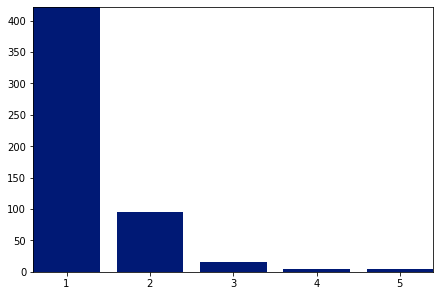

In [9]:
nstatesdist = counts(nstates, maximum(nstates))
bar(1:length(nstatesdist), nstatesdist);

In [10]:
# TODO: Check in traceroute that there is no "spurious" hops

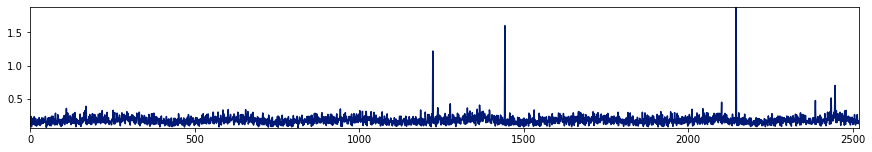

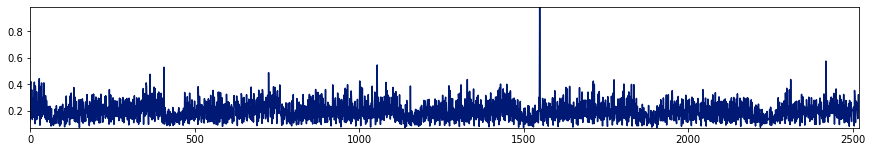

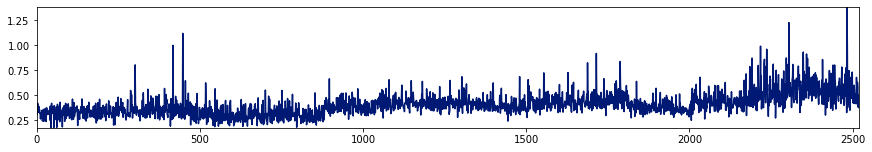

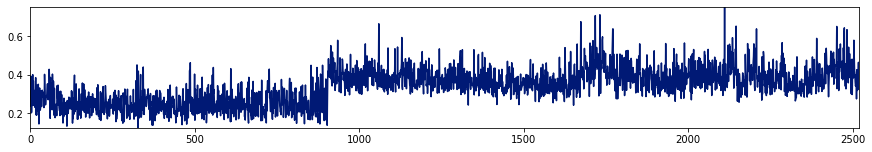

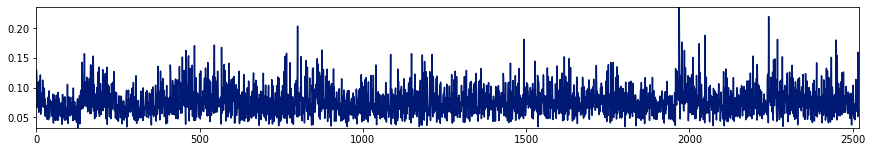

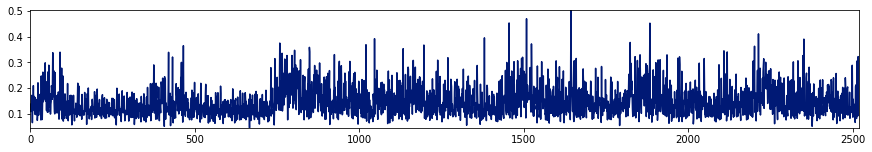

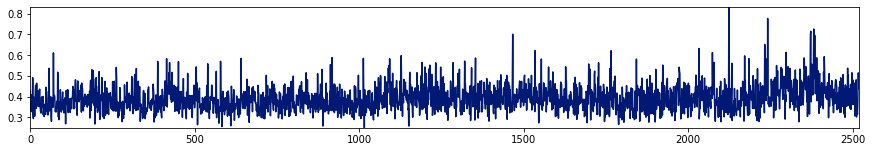

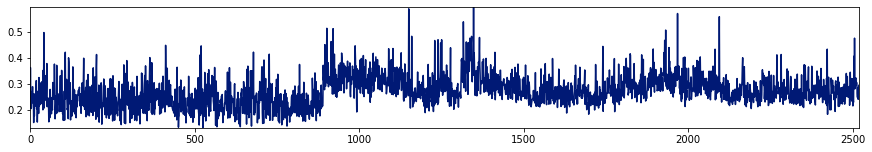

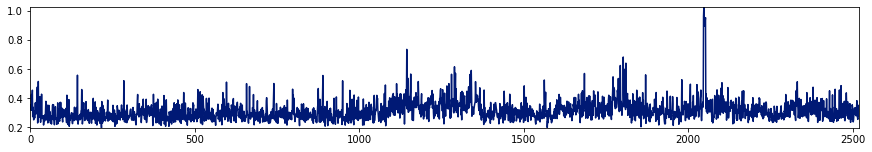

In [11]:
for m in models[nstates .>= 4]
    figure(figsize = (12,2))
    plot(coalesce.(m.data, NaN))
end

### Analysis of non-self measurements

In [12]:
# TODO: Re-do analysis with 10% of the pairs instead of 1%.
# TODO: ACF insides the states?

In [13]:
# TODO: Number of states vs. number of hops ?
# TODO: Comparer modeles appris sur 1 et 3 jours vs. les sous-sequences
# de 1 et 3 jours sur un modele appris sur 7 jours (est-ce que ca match ?).

In [14]:
files = glob("*.model.json", "../data/ping_v4_1580511600_1581116400_noself_pairs/");

In [15]:
# Build ping/traceroute pairs
ping_traceroute_pairs = []
for file in files
    file = replace(file, ".model.json" => "")
    msm_id, _ = parsename(file)
    sibling = replace(file, "ping" => "traceroute")
    sibling = replace(sibling, string(msm_id) => string(ping_traceroute[msm_id]))
    push!(ping_traceroute_pairs, (file, sibling))
end

In [16]:
models = map(x -> parsefile(DataSegmentationModel, x), files);

In [17]:
nstates = map(x -> size(x.model, 1), models);

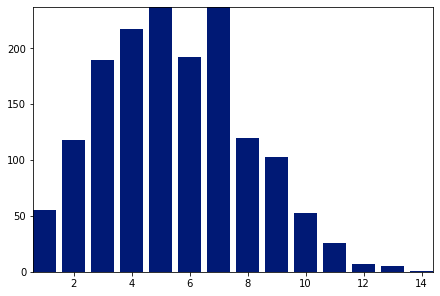

In [18]:
nstatesdist = counts(nstates, maximum(nstates))
bar(1:length(nstatesdist), nstatesdist);

In [19]:
# Compute avg. durations by states
durations, stds = [], []
for model in models
    for (state, segments) in group(segments(model.state))
        data = model.data[segments]
        push!(durations, mean(length, segments))
        push!(stds, std(skipmissing(data)))
    end
end

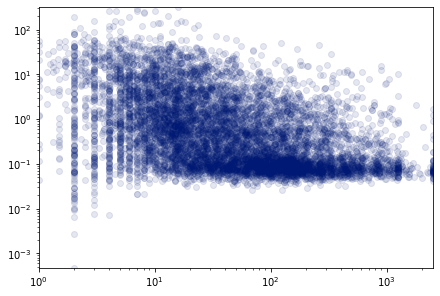

In [20]:
fig, ax = subplots()
ax.scatter(durations, stds, alpha = 0.1)
ax.set_xscale("log")
ax.set_yscale("log")

#### Traceroutes

In [21]:
# How many AS paths are associated to a given state?
# Cas extreme => 1 nouvel etats par timestep = exactement 1 AS/IP path par état
# How many states are associated to a given AS path?
# Cas extreme => 1 seul etat pour toute la serie = exactement 1 etat par AS/IP path
# => On veut que ces deux conditions soit le plus rapproche (= bonne segmentation)
# TODO: 3 levels : IP, router (alias resolution), AS

In [22]:
asntree = load_asntree("/home/maxmouchet/Clones/goasn/rib.20200208.0800.bz2.txt");

In [ ]:
counts_ab = Int[]
counts_ba = Int[]
@showprogress for (ping_file, traceroute_file) in ping_traceroute_pairs[1:100]
    model = parsefile(DataSegmentationModel, "$(ping_file).model.json")
    traceroute = TracerouteRecord.(load_traceroute(traceroute_file, asntree))
    ping_segments = segments(model)
    traceroute_segments = segments(labelize(traceroute))
    res1 = map(x -> length(x), values(reduce(bidirectional_mapping(ping_segments, traceroute_segments)[1])))
    res2 = map(x -> length(x), values(reduce(bidirectional_mapping(ping_segments, traceroute_segments)[2])))
    push!(counts_ab, res1...)
    push!(counts_ba, res2...)
end

Progress:   1%|▍                                        |  ETA: 0:03:03

In [ ]:
d = counts(counts_ab, maximum(counts_ab))
bar(1:length(d), d);

In [ ]:
d = counts(counts_ba, maximum(counts_ba))
bar(1:length(d), d);